In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [49]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [51]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [52]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [53]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [54]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [55]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [56]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [57]:
# Get a list of column names and types
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [58]:
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [59]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

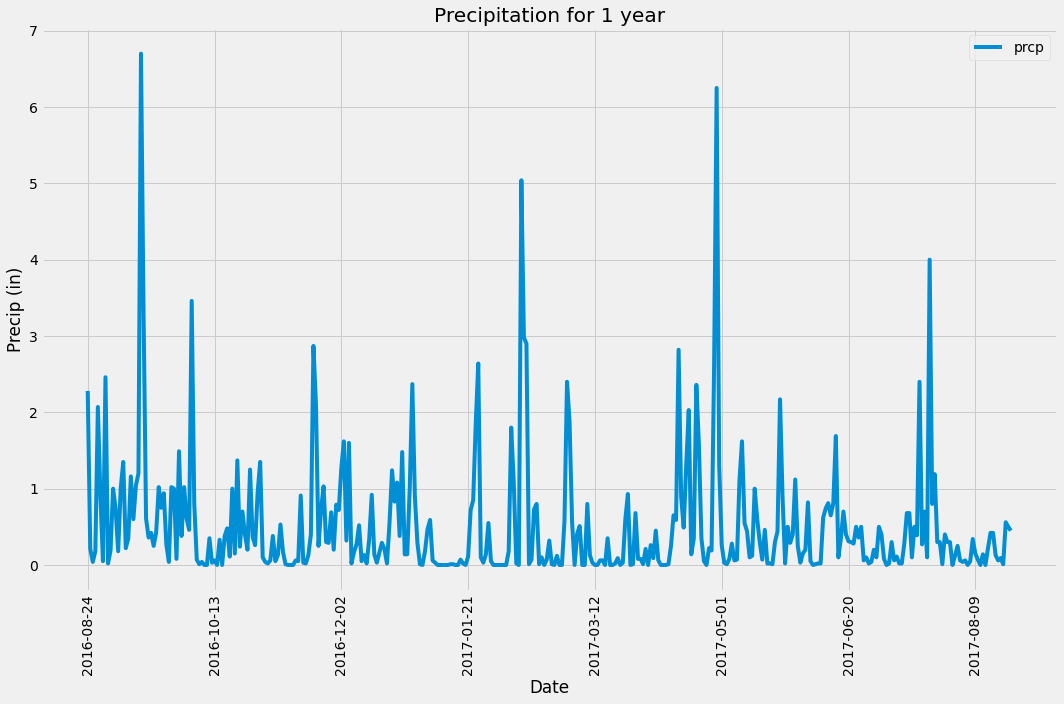

In [60]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
#precipitation is in prcp column

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#Note you do not pass in the date as a variable to your query 
# Perform a query to retrieve the data and precipitation scores
year_precipitation = session.query(Measurement.date, func.max(Measurement.prcp)).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) > dt.date(2016, 8, 23)).\
    group_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
year_precipitation_df = pd.DataFrame(year_precipitation, columns = ['date', 'prcp'] )
year_precipitation_df.set_index('date', inplace=True)
#year_precipitation_df
# Sort the dataframe by date
year_precipitation_df.sort_values('date')
#year_precipitation_df
# Use Pandas Plotting with Matplotlib to plot the data
year_precipitation_df.plot(figsize=(15,10), title="Precipitation for 1 year")
plt.xlabel("Date")
plt.ylabel("Precip (in)")
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()


In [61]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(year_precipitation_df.describe())

             prcp
count  365.000000
mean     0.517288
std      0.829196
min      0.000000
25%      0.040000
50%      0.250000
75%      0.650000
max      6.700000


# Exploratory Station Analysis

In [62]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [63]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [64]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_stats = session.query(func.min(Measurement.tobs),
                       func.max(Measurement.tobs),
                       func.avg(Measurement.tobs).\
                        filter(Measurement.station == 'USC00519281')).all()
active_station_stats

[(53.0, 87.0, 71.66378066378067)]

In [65]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#one_year_ago from earlier for year period
temp_obv = session.query(Measurement.station, Measurement.tobs).\
            filter(Measurement.station == 'USC00519281').\
            filter(Measurement.date>= one_year_ago).all()
    
temp_ob_df = pd.DataFrame(temp_obv)
temp_ob_df

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0
...,...,...
347,USC00519281,77.0
348,USC00519281,77.0
349,USC00519281,76.0
350,USC00519281,76.0


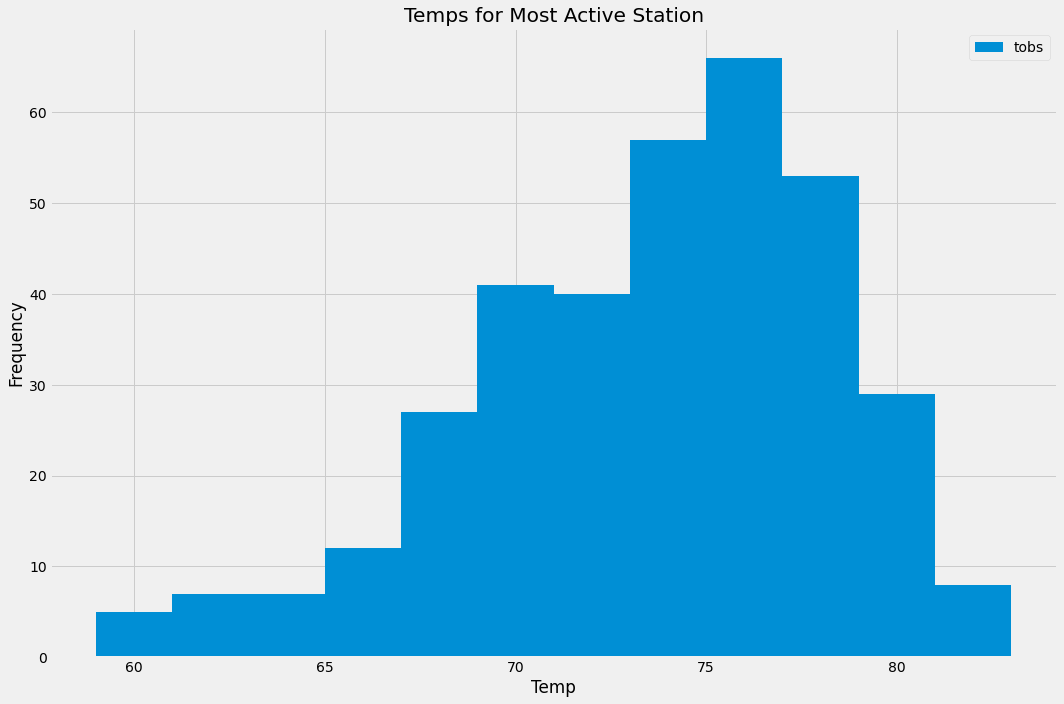

In [66]:
#histogram
temp_ob_df.plot.hist(figsize=(15,10), bins=12, title="Temps for Most Active Station")
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close session

In [67]:
# Close Session
session.close()